#**WEB TRAFFIC TIME SERIES FORECASTING**
 **By: Prabu KL**
______________________________________________________________________
Time series forecasting uses information regarding historical values and associated patterns to predict future activity. Most often, this relates to trend analysis, cyclical fluctuation analysis, and issues of seasonality.

**HOW TO ANALYZE**

Statistical techniques can be used to analyze time series data in two key ways:



*   To generate inferences on how one or more variables affect some variable of interest over time
*  To forecast future trends.  





**Example:**

Historical stock prices, earnings, GDP, or other sequences of financial or economic data can be analyzed as a time series.

**Why Web Traffic is important in Forecasting?**


1.   To understand the trends in the future from the past data
2.   To determine the server capacity of their website
3.   To understand what we as a society are interested in, by analyzing the pages visited by users across the globe it would be easier to understand where we are heading to.
4.   To determine how much a particular site is visited to know what is the conversion rate.





**About Datasets:**

**train_.csv** - contains traffic data. This a csv file where each row corresponds to a particular article and each column correspond to a particular date. Some entries are missing data. The page names contain the Wikipedia project (e.g. en.wikipedia.org), type of access (e.g. desktop) and type of agent (e.g. spider). In other words, each article name has the following format: 'name_project_access_agent' (e.g. 'AKB48_zh.wikipedia.org_all-access_spider').

**key_.csv** - gives the mapping between the page names and the shortened Id column used for prediction

# **DATA ANALYSIS AND VISUALIZATIONS**

In [1]:
#Importing Libraries
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import calendar
import matplotlib.pyplot as plt
import plotly.graph_objs as go


In [40]:
import csv  # Import the csv module

# Reading the datasets with appropriate settings
train_df = pd.read_csv("/content/train_1.csv", engine='python', on_bad_lines='skip')
key_df = pd.read_csv("/content/key_1.csv", engine='python', quoting=csv.QUOTE_NONE, on_bad_lines='skip')

In [44]:
train_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,lang
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0,zh
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0,zh
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0,zh
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0,zh
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0,zh


In [41]:
key_df.head()

,"""Page""","""Id"""
0,"""!vote_en.wikipedia.org_all-access_all-agents_...",bf4edcf969af
1,"""!vote_en.wikipedia.org_all-access_all-agents_...",929ed2bf52b9
2,"""!vote_en.wikipedia.org_all-access_all-agents_...",ff29d0f51d5c
3,"""!vote_en.wikipedia.org_all-access_all-agents_...",e98873359be6
4,"""!vote_en.wikipedia.org_all-access_all-agents_...",fa012434263a


In [45]:
#Printing the size of both datasets
print("Train--- ", train_df.shape)
print("Key----- ", key_df.shape)

Train---  (20182, 552)
Key-----  (541172, 2)


In [46]:
page= pd.DataFrame([i.split("_")[-3:] for i in train_df["Page"]])
page.columns = ["Site", "Access_Type", "Agent"]
page.describe()

,Site,Access_Type,Agent
count,20182,20182,20182
unique,6,3,2
top,en.wikipedia.org,desktop,all-agents
freq,4975,7776,16163


We can see that even if there are huge number of data in each column, the number of unique values are quite less and are extractable, so let's explore the unique values.


In [47]:
site_column = list(page['Site'].unique())
access_column =list(page['Access_Type'].unique())
agents_column= list(page['Agent'].unique())
print("Unique site columns:", site_column)
print('-----------------------------------------------------------------------------------------------------------------------')
print("Unique access columns:", access_column)
print('-----------------------------------------------------------------------------------------------------------------------')
print( "Unique agent columns:", agents_column)

Unique site columns: ['zh.wikipedia.org', 'fr.wikipedia.org', 'en.wikipedia.org', 'commons.wikimedia.org', 'ru.wikipedia.org', 'www.mediawiki.org']
-----------------------------------------------------------------------------------------------------------------------
Unique access columns: ['all-access', 'desktop', 'mobile-web']
-----------------------------------------------------------------------------------------------------------------------
Unique agent columns: ['spider', 'all-agents']


Lets see among the pages that are visited, which language stands out.
For that we have to create a separate column to specify the language of the page.
You can see from the site column in the page data frame, we can observe that the first two letters represent the language of the page, If there is a way by which this information can be extracted then our analysis process will be easier.

Since the language is represented by two letter we can extract it by using regular expressions.

In [48]:
import re
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'na'

Observe the function defined above.The function takes a page as a parameter and searches the page for a string starting with two letters followed by .wikipedia.org.  If there is such a string then the first two letters is filtered out, else na(not available) is returned.

Text(0.5, 1.0, 'Language - distribution')

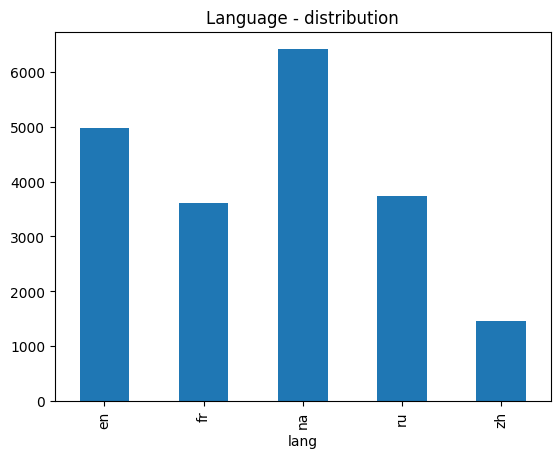

In [49]:
train_df['lang'] = train_df.Page.map(get_language)
#Keeping a language column in the page dataframe as well
page['lang'] = train_df.Page.map(get_language)
page["lang"].value_counts().sort_index().plot.bar().set_title('Language - distribution')

The above plot shows the language distribution in the dataframe.

Now let us count the occurances of each language in the data frame. For that lets use a counter object from collections.

In [50]:
from collections import Counter
print(Counter(train_df.lang))

Counter({'na': 6405, 'en': 4975, 'ru': 3729, 'fr': 3604, 'zh': 1469})


There are 7 languages plus the media pages. The languages used here are: **English, Japanese, German, French, Chinese, Russian, and Spanish**. This will make any analysis of the URLs difficult since there are four different writing systems to be dealt with (Latin, Cyrillic, Chinese, and Japanese). Here, we will create dataframes for the different types of entries. Then we will  calculate the sum of all views.

In [51]:
lang = {}
lang['en'] = train_df[train_df.lang=='en'].iloc[:,0:-1]
lang['ja'] = train_df[train_df.lang=='ja'].iloc[:,0:-1]
lang['de'] = train_df[train_df.lang=='de'].iloc[:,0:-1]
lang['na'] = train_df[train_df.lang=='na'].iloc[:,0:-1]
lang['fr'] = train_df[train_df.lang=='fr'].iloc[:,0:-1]
lang['zh'] = train_df[train_df.lang=='zh'].iloc[:,0:-1]
lang['ru'] = train_df[train_df.lang=='ru'].iloc[:,0:-1]
lang['es'] = train_df[train_df.lang=='es'].iloc[:,0:-1]

sums = {}
for key in lang:
    sums[key] = lang[key].iloc[:,1:].sum(axis=0) / lang[key].shape[0]

In the above cell we can see that a new dictionary is created called sums and then total sum of views for each language is appended to the dictionary with the language as keys.

Creating a list of numbers in the range of number of rows belonging to largest language. Plot a figure with the days in days list in x axis and each key value in sums dictionary in y axis.

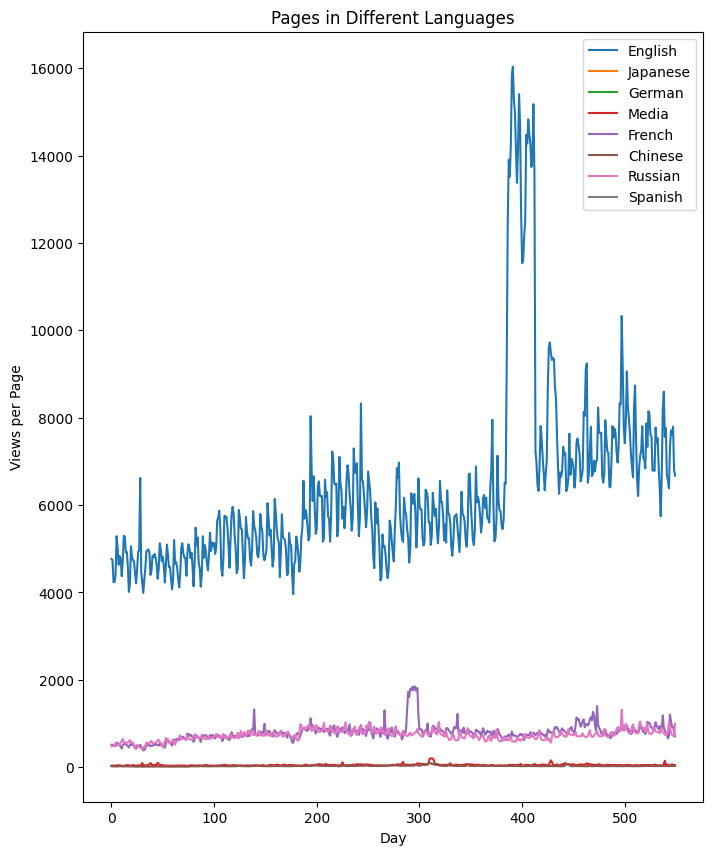

In [52]:
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1,figsize=[8,10])
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Pages in Different Languages')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }

for key in sums:
    plt.plot(days,sums[key],label = labels[key] )

plt.legend()
plt.show()

**English** shows much larger views per page, it may be because of the fact that Wikipedia is a US based page. We can see a spike in page views for english and Russian pages around the day 400, english shows more spikes later.It is also interesting to note that the Spanish data is almost periodic in nature.

Now lets melt the dataframe into a desirable form, that is page values are treated as identifiers and the variable as date and value as the number of visits, the values and variables are unpivoted to form row values.

Pandas melt() function is used to change the DataFrame format from wide to long. It’s used to create a specific format of the DataFrame object where one or more columns work as identifiers. All the remaining columns are treated as values and unpivoted to the row axis and only two columns – variable and value.

In [53]:
chunk_size = 100000  # You can adjust this size as needed

# Initialize an empty list to hold the chunks
chunks = []

# Read the CSV file in chunks
try:
    for chunk in pd.read_csv("/content/train_1.csv", chunksize=chunk_size, engine='python', on_bad_lines='skip'):
        chunks.append(chunk)
    # Combine the chunks into a single DataFrame
    train_df_2 = pd.concat(chunks, ignore_index=True)
except pd.errors.ParserError as e:
    print(f"Error parsing the file: {e}")

# Proceed with your data manipulation
train = pd.melt(train_df_2[list(train_df_2.columns[-50:]) + ['Page']], id_vars='Page', var_name='date', value_name='Visits')
train_df_2.head()


,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


You can observe the above data frame and understand what pandas melting actually do, now we see is number of visits a particular page has on a particular date.Looks more convenient for analysis right?

Now lets look at the data type of each column

In [54]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009100 entries, 0 to 1009099
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   Page    1009100 non-null  object 
 1   date    1009100 non-null  object 
 2   Visits  967031 non-null   float64
dtypes: float64(1), object(2)
memory usage: 23.1+ MB


In [55]:
train['date'] = train['date'].astype('datetime64[ns]')

Now we have to add a column weekend to the dataframe using the dt.dayofweek method.

This code  use integer division (//) to test whether the dayofweek attribute of the DatetimeIndex is less than 5. Normally this would return just a True or False, but tacking on the astype(float) at the end returns a 1 or 0 rather than a boolean.



In [56]:
train['weekend'] = ((train.date.dt.dayofweek) // 5 == 1).astype(float)

Creating a dataframe with the median/mean value of visits for each page by grouping the train dataframe on page and computing the median/mean.

In [32]:
median = pd.DataFrame(train.groupby(['Page'])['Visits'].median())
median.columns = ['median']
mean = pd.DataFrame(train.groupby(['Page'])['Visits'].mean())
mean.columns = ['mean']

Join the mean and median data frame into the train data frame and set the index values to be the page column values, also create a new column weekday by filtering out the date values and applying a function on the value which returns which weekday the date belongs to.

In [33]:
train = train.set_index('Page').join(mean).join(median)
train.reset_index(drop=False,inplace=True)
train['weekday'] = train['date'].apply(lambda x: x.weekday())

Feature engineering with dates, creating a year, month and day column by applying dt.year, dt.month, dt.day on the filtered out date values of the train data frame.

In [57]:
train['year']=train.date.dt.year
train['month']=train.date.dt.month
train['day']=train.date.dt.day
train.head(3)

,Page,date,Visits,weekend,year,month,day
0,2NE1_zh.wikipedia.org_all-access_spider,2016-11-12,13.0,1.0,2016,11,12
1,2PM_zh.wikipedia.org_all-access_spider,2016-11-12,12.0,1.0,2016,11,12
2,3C_zh.wikipedia.org_all-access_spider,2016-11-12,6.0,1.0,2016,11,12


This is the new formed data frame, observe the weekday column to understand what the weekday() function actually does.

**Now lets do some plotting to understand the new data frame and the data**

**1) This is to plot the mean value of visits on  pages on a particular date.**

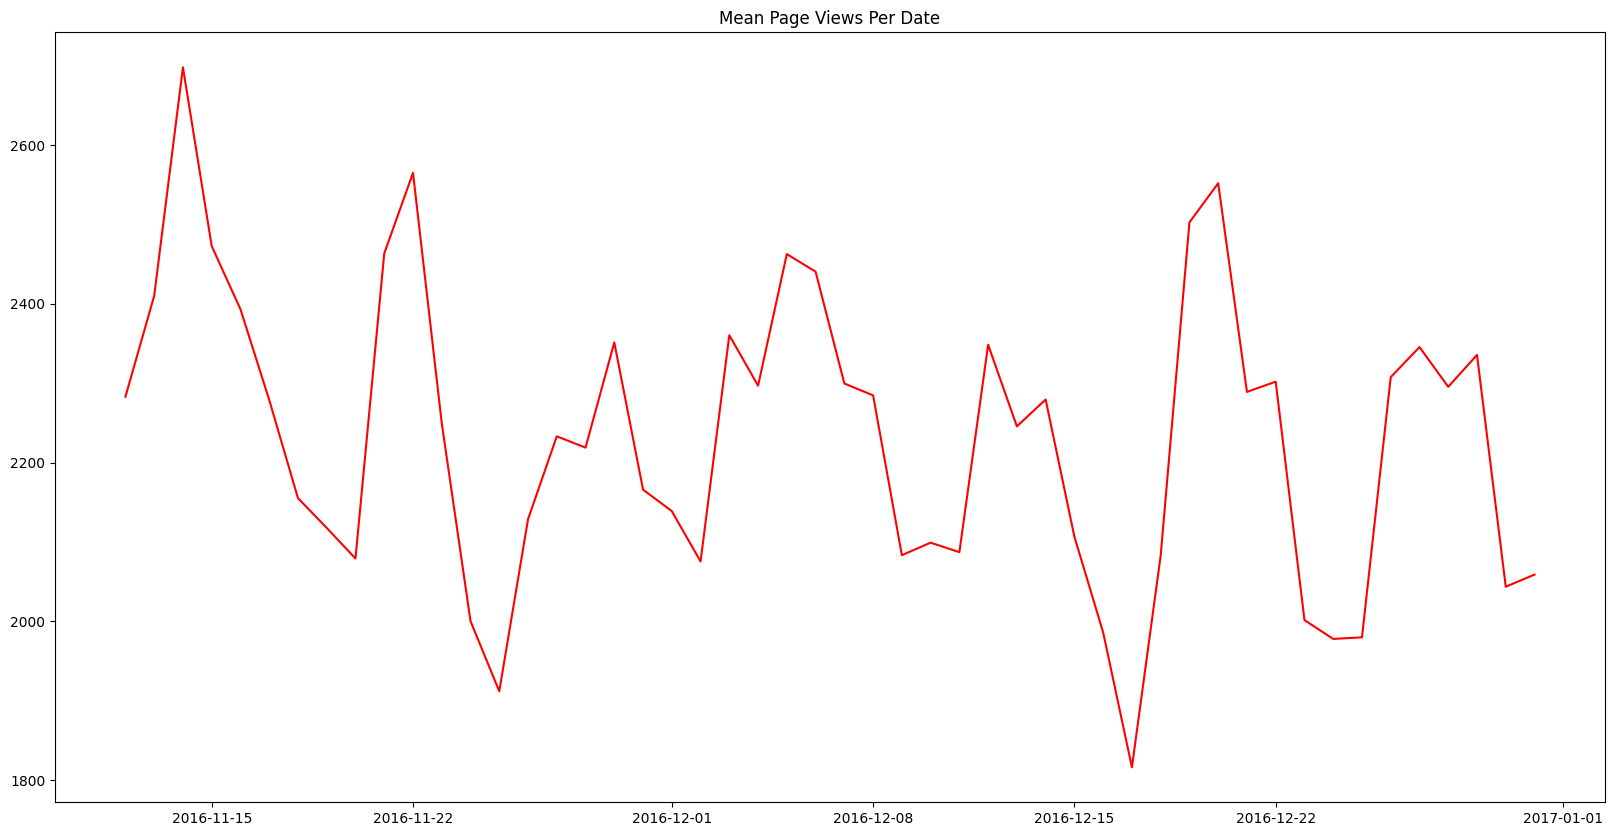

In [58]:
plt.figure(figsize=(20, 10))
mean_g = train[['Page','date','Visits']].groupby(['date'])['Visits'].mean()
plt.plot(mean_g,c='red')
plt.title('Mean Page Views Per Date')
plt.show()

In [59]:
train[['Page','date','Visits']].groupby(['date'])['Visits'].mean().head(3)

,Visits
date,
2016-11-12,2283.024846
2016-11-13,2410.060606
2016-11-14,2698.021772


We can see that the mean visit data dosent vary periodically and has unexpected peaks and drops.We see that the biggest beek occurs before 2016-11-15 and a very deep drop occurs between 2016-11-22 and 2016-12-01

**2) This is to plot the median value of visits on  pages on a particular date.**


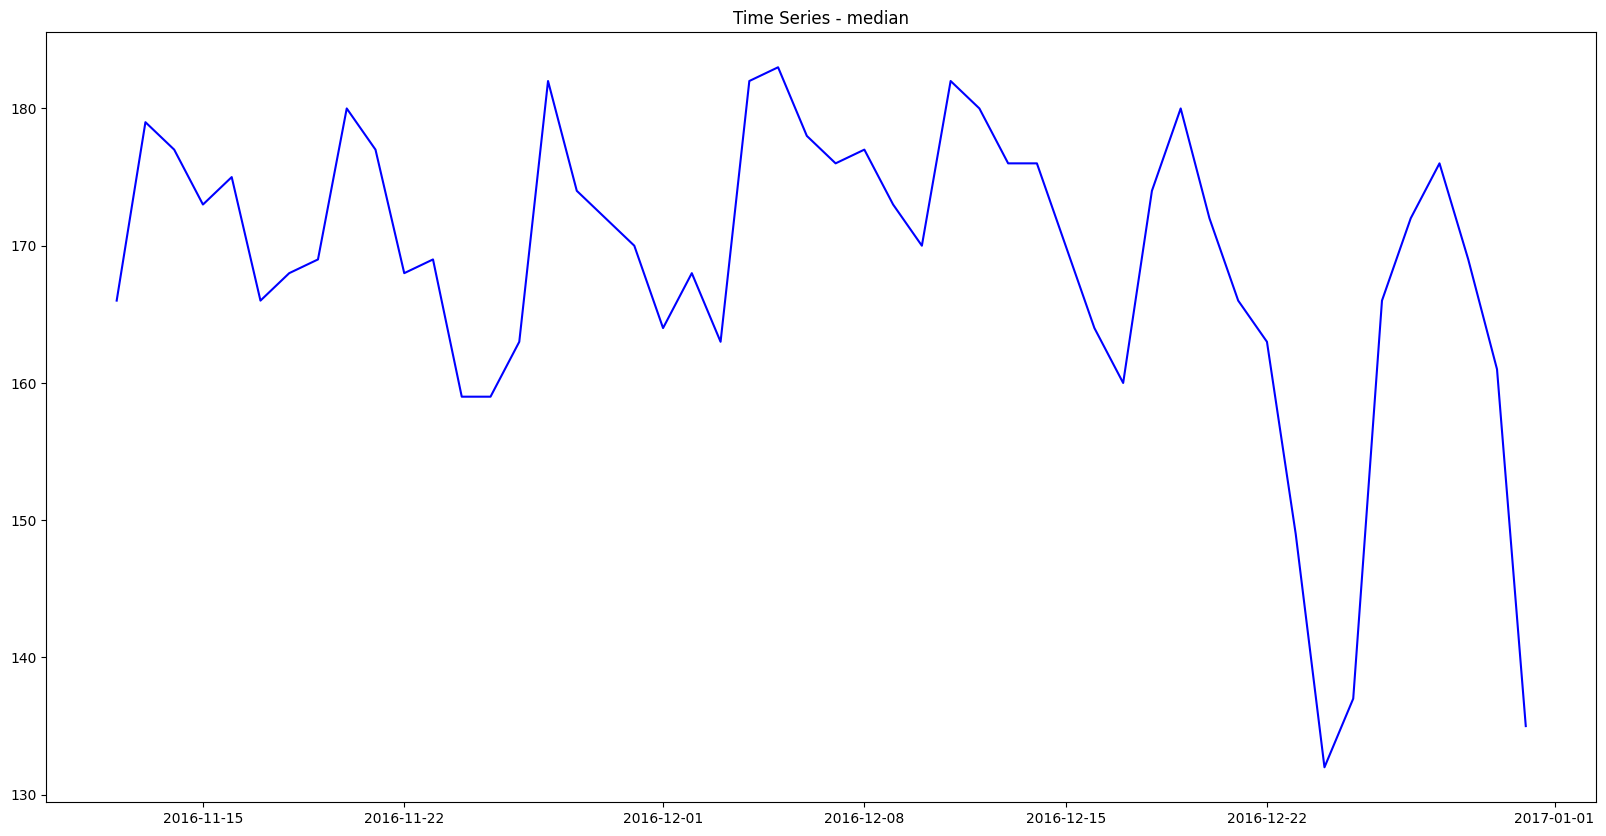

In [37]:
plt.figure(figsize=(20, 10))
median_g = train[['Page','date','Visits']].groupby(['date'])['Visits'].median()
plt.plot(median_g, color = 'b')
plt.title('Time Series - median')
plt.show()

This plot follows a similar concept but shows median values instead.

_____________________________________________________________________________________
_____________________________________________________________________________________